# Nonlinear Convolution Kernel with Tensorflow

Dual Problem: 

$$ max \left( \sum_{i=1}^n b_i - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n{y_i y_j b_i b_j \cdot k(x_i, x_j)} \right) $$

Subject to restrictions:
- $ \sum_{i=1}^n{b_i y_i} = 0 $
- $ 0 \le b_i \le \frac{1}{2n\gamma}~=~0 \le b_i \le C $

$b = $ Lagrange Multipliers

$k$ is called the SVM **kernel**.
- Lineal Case $k(x_i,x_j) = x_i \cdot x_j$
- General Case $k(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)$

- Gaussian Kernel: $ k(x_i, x_j) = e^{-\gamma ||x_i-x_j||^2}$
    - Where $\gamma = ~ \frac{1}{2\sigma^2}$ 

Note: $|| operation ||^2$ is the squared Euclidean distance.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

plt.style.use("ggplot")

First, let's create a circle-shaped dataset using sklearn's method **make_circles**.

In [2]:
# Create circular data
(x_vals, y_vals) = datasets.make_circles(n_samples= 1000, noise= 0.1, factor= 0.5)

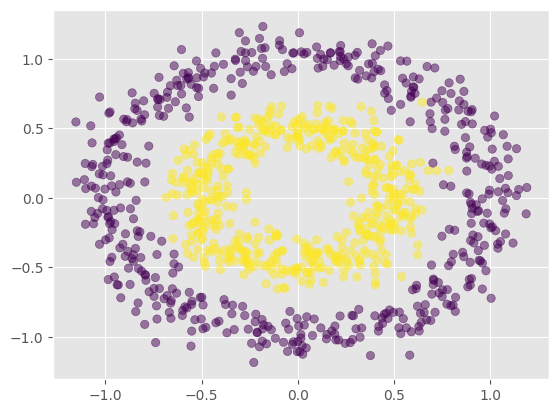

In [3]:
# Replace 0s for -1
y_vals = np.where(y_vals == 1,1,-1)

# Plot the data
plt.scatter(x_vals[:,0], x_vals[:,1], c= y_vals, alpha= 0.5)
plt.show()

**How to calculate RBF Kernel:**

$$ kernel(\vec{x}) = e^{-\gamma || x_i - x_j ||^2} $$

We need to subtract all possible pairs of samples, for instance let's say we have the next data:

$ \vec{x} = \begin{pmatrix}
            [0,~0]\\
            [1,~2]\\
            [3,~4]\\
            \end{pmatrix}
            = \begin{pmatrix}
            x_1\\
            x_2\\
            x_3\\
            \end{pmatrix} \in \mathbb R_{m \times 1}$

$ x_i - x_j = 
            \begin{pmatrix}
            [x_1-x_1], [x_1-x_2], [x_1-x_3]\\
            [x_2-x_1], [x_2-x_2], [x_2-x_3]\\
            [x_3-x_1], [x_3-x_2], [x_3-x_3]\\
            \end{pmatrix} 
            = \begin{pmatrix}
            [0,0],[-1,-2],[-3,-4]\\
            [1,2],[0,0],[-2,-2]\\
            [3,4],[2,2],[0,0]\\
            \end{pmatrix} \in \mathbb {m \times m}$

Then calculate the $l_2$ norm squared for each sample.

$||x_i - x_j||^2 = 
            \begin{pmatrix}
            (0.,~5.,~25.)\\
            (5.,~0.,~8.)\\
            (25.,~8.,~0.)\\
            \end{pmatrix}$

And finally the exponential:

$kernel(\vec{x})= e^{-\gamma|| x_i - x_j ||^2} = 
\begin{pmatrix}
            (1.0,~1.3e^{-11},~5.1e^{-55})\\
            (1.3e^{-11},~1.0,~4.2e^{-18})\\
            (5.1e^{-55},~4.2e^{-18},~1.0)\\
            \end{pmatrix}, ~ \gamma = -5.0$

And we're done.

**How to Compute the Dual Problem**

* Compute the first sum. 
    * The first addition is simply adding the lagrange multipliers and you will get a constant.
* Second Sum.
    * First, we will calculate the cross multiplication between each pair of $~y_{data}~$, for example:
    
        if $y_{data} \in \mathbb R_{m \times 1}$ then we need to compute $y_{data} \times y_{data}^T = y_{cross} \in \mathbb R_{m \times m}$
    * Then, to compute the $alpha_{cross}$, let's say we have the following vector:
    
        $alpha \in \mathbb R_{1 \times m}$ then we need to compute $alpha^T \times alpha = alpha_{cross} \in \mathbb R_{m \times m}$
        
    * And finally compute the kernel that we did before, which give us a matrix $~~~kernel(\vec{x}) \in \mathbb R_{m \times m}$
    
* Finally, we compute the second sum:
    
    $second_{sum}=~\frac{1}{2}\sum{~y_{cross}~\times~alpha_{cross}~\times~kernel(\vec{x})}$
    
    $first_{sum},~second_{sum} \in \mathbb R$
    
    $loss=~first_{sum}~-~second_{sum}$
    

And that's it.

In [4]:
batch_size = 1000

# Transform the circular data to constants
x_data = tf.constant(x_vals, dtype= tf.float32)
y_data = tf.constant(y_vals, dtype= tf.float32, shape= [batch_size, 1])

# Hyperparameters
C = tf.constant(1.0, dtype= tf.float32) # Regularization term
alpha = tf.Variable(tf.zeros(shape= [1, batch_size])) # Lagrance Multipliers
gamma = tf.constant(50., dtype= tf.float32) # RBF Kernel gammaa

# RBF Kernel
@tf.function
def rbf_kernel(x):
    x_cross = tf.square(tf.linalg.norm(tf.expand_dims(x, 1) - x_data, axis= 2))
    return tf.exp(-gamma * x_cross)

# Function to Predict
def svm_predict(x, alpha):
    kernel = rbf_kernel(x)
    prediction = tf.multiply(alpha, tf.transpose(y_data)) @ tf.transpose(kernel)
    return tf.sign(prediction)

# Get Accuracy
@ tf.function
def get_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.transpose(y_true), y_pred), dtype= tf.float32))

# Loss Function
@tf.function
def objective_function(x, y, alpha):
    kernel = rbf_kernel(x)
    first_sum = tf.reduce_sum(alpha)
    y_cross = y @ tf.transpose(y)
    alpha_cross = tf.transpose(alpha) @ alpha
    second_sum = tf.reduce_sum(y_cross * alpha_cross * kernel)
    return tf.negative(first_sum - 0.5 * second_sum)


# Optimizer
eta= 0.001
my_opt = tf.optimizers.legacy.SGD(learning_rate= eta)

loss_vect = []
acc_vect = []
for ite in range(1, 101):
    rand_ind = np.random.choice(x_data.shape[0], size= x_data.shape[0],replace= False)
    rand_x = tf.gather(x_data, rand_ind)
    rand_y = tf.expand_dims(tf.gather(tf.squeeze(y_data), rand_ind), 1)
    with tf.GradientTape() as g:
        g.watch(alpha)
        loss = objective_function(rand_x, rand_y, alpha)
    gradient = g.gradient(loss, [alpha])
    my_opt.apply_gradients(zip(gradient, [alpha]))
    alpha = tf.Variable(tf.clip_by_value(alpha, 0., C))
    
    preds = svm_predict(rand_x, alpha)
    acc = get_accuracy(rand_y, preds)

    loss_vect.append(loss.numpy())
    acc_vect.append(acc.numpy())
    if ite % 10 == 0:
        print(f"Iteration: {ite} -- Loss: {loss.numpy()} -- Accuracy: {acc.numpy()}")

Iteration: 10 -- Loss: -9.009626388549805 -- Accuracy: 0.9950000047683716
Iteration: 20 -- Loss: -18.73419952392578 -- Accuracy: 0.9950000047683716
Iteration: 30 -- Loss: -29.062480926513672 -- Accuracy: 0.9950000047683716
Iteration: 40 -- Loss: -38.6584358215332 -- Accuracy: 0.9950000047683716
Iteration: 50 -- Loss: -49.20225143432617 -- Accuracy: 0.9950000047683716
Iteration: 60 -- Loss: -58.94490051269531 -- Accuracy: 0.9950000047683716
Iteration: 70 -- Loss: -68.46892547607422 -- Accuracy: 0.9950000047683716
Iteration: 80 -- Loss: -79.17052459716797 -- Accuracy: 0.9950000047683716
Iteration: 90 -- Loss: -89.3138198852539 -- Accuracy: 0.9950000047683716
Iteration: 100 -- Loss: -97.22528076171875 -- Accuracy: 0.9950000047683716


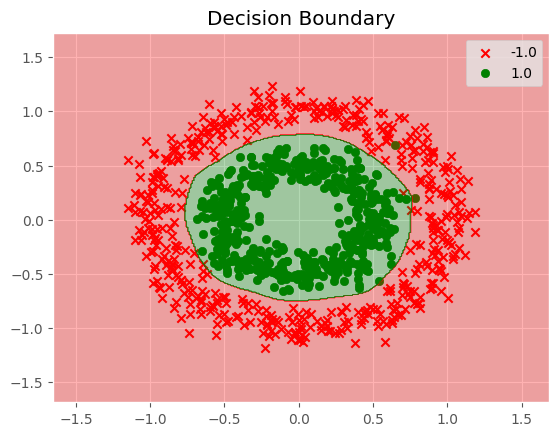

In [5]:
from matplotlib.colors import ListedColormap

x_set, y_set = x_data.numpy(), y_data.numpy().reshape(-1)

X1, X2 = np.meshgrid(np.arange(start= x_set[:, 0].min() - 0.5, stop= x_set[:, 0].max() + 0.5, step= 0.01), 
                     np.arange(start= x_set[:, 1].min() - 0.5, stop= x_set[:, 1].max() + 0.5, step= 0.01))

y_grid = svm_predict(tf.constant(np.c_[X1.ravel(),X2.ravel()], dtype= tf.float32), alpha).numpy().reshape(X1.shape)

colors = ["red", "green"]
marker = ["x", "o"]
for i, label in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == label, 0], x_set[y_set == label, 1], c = colors[i], marker= marker[i], label= label)

plt.contourf(X1, X2, y_grid, cmap= ListedColormap(("red", "green")), alpha= 0.3)
plt.title("Decision Boundary")
plt.legend()
plt.show()

The followed code it's the same code as before but the kernel has been computed in a different way.

$\vec{x_{squared}}=\begin{pmatrix}
            [0,~0]\\
            [1,~2]\\
            [3,~4]\\
            \end{pmatrix}^2
            ~~~~~~~~
            dist= \begin{pmatrix}
            sum[0,~0]\\
            sum[1,~4]\\
            sum[9,~16]\\
            \end{pmatrix} = 
            \begin{pmatrix}
            0.0\\
            5.0\\
            25.0\\
            \end{pmatrix}$

$||x_i - x_j||^2= dist - 2.0 (\vec{x} \cdot \vec{x}^T) + dist^T = 
            \begin{pmatrix}
            0.0\\
            5.0\\
            25.0\\
            \end{pmatrix} - 2.0\left( 
            \begin{pmatrix}
            [0,~0]\\
            [1,~2]\\
            [3,~4]\\
            \end{pmatrix} \cdot \begin{pmatrix}
            [0,~0], [1,~2], [3,~4]
            \end{pmatrix}\right) + 
            \begin{pmatrix}
            0.0, 5.0, 25.0
            \end{pmatrix}$

$||x_i - x_j||^2  = 
            \begin{pmatrix}
            (0.,~5.,~25.)\\
            (5.,~0.,~8.)\\
            (25.,~8.,~0.)\\
            \end{pmatrix}$

As you can see, we got the same result for $||x_i - x_j||^2$ as before.

Note. The procedure we carried out was to transform the training data, if you want to transform new data then you need to compute the $dist$ for the new data and then replace the $dist^T$ for the $dist_{new}^T$ and replace the $\vec{x}^T$ for $\vec{x}_{new}^T$ and the expression will be like the following:

* $||\vec{x}_{new} - \vec{x}||^2 = dist - 2.0 (\vec{x} \cdot \vec{x}_{new}^T) + dist_{new}^T$

In [6]:
batch_size = 1000

# Data
(x_vals, y_vals) = datasets.make_moons(n_samples= 1000, noise= 0.1)
y_vals = np.where(y_vals == 1,1, -1)

x_data = tf.constant(x_vals, dtype= tf.float32)
y_target = tf.constant(y_vals, shape= [x_vals.shape[0],1], dtype= tf.float32)

# Lagrange Multipliers
alpha = tf.Variable(tf.zeros(shape= [1, batch_size], dtype= tf.float32))
C = tf.constant(1.0) # constrain the range from 0 to 1.

# RBF kernel Hyperparameter
gamma = tf.constant(50.0, dtype= tf.float32)

# RBF Kernel
def gaussian_kernel(x):
    rA = tf.reshape(tf.reduce_sum(tf.square(x_data), axis= 1), [-1,1])
    rB = tf.reshape(tf.reduce_sum(tf.square(x), axis= 1), [-1,1])
    sq_distance = (rA - (2.0 * (x_data @ tf.transpose(x)))) + tf.transpose(rB)
    my_kernel = tf.exp(-gamma * tf.abs(sq_distance))
    return my_kernel

# Loss Function
@tf.function
def loss_function(x,y, b):
    kernel = gaussian_kernel(x)
    model_output = tf.matmul(b, kernel)
    first_sum = tf.reduce_sum(b)
    b_vect_cross = tf.matmul(tf.transpose(b),b)
    y_target_cross = tf.matmul(y, tf.transpose(y))
    second_sum = tf.reduce_sum(tf.multiply(kernel, tf.multiply(b_vect_cross, y_target_cross)))
    loss = tf.negative(tf.subtract(first_sum, 0.5*second_sum))
    return loss

# Prediction Function
@ tf.function
def predict(data, b):
    kernel = gaussian_kernel(data)
    pred_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), kernel)
    return tf.sign(pred_output)

# Get Accuracy
@ tf.function
def get_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.transpose(y_true), y_pred), dtype= tf.float32))

# Optimizer
eta= 0.01
my_opt = tf.optimizers.legacy.SGD(learning_rate= eta)


loss_vect = []
acc_vect = []
for ite in range(1, 101):
    rand_ind = np.random.choice(x_data.shape[0], size= x_data.shape[0],replace= False)
    rand_x = tf.gather(x_data, rand_ind)
    rand_y = tf.expand_dims(tf.gather(tf.squeeze(y_target), rand_ind), 1)
    with tf.GradientTape() as g:
        g.watch(alpha)
        loss = loss_function(rand_x, rand_y, alpha)
    gradient = g.gradient(loss, [alpha])
    my_opt.apply_gradients(zip(gradient, [alpha]))
    alpha = tf.Variable(tf.clip_by_value(alpha, 0., C))

    preds = predict(rand_x, alpha)
    acc = get_accuracy(rand_y, preds)

    loss_vect.append(loss.numpy())
    acc_vect.append(acc.numpy())
    if ite % 10 == 0:
        print(f"Iteration: {ite} -- Loss: {loss.numpy()} -- Accuracy: {acc.numpy()}")

Iteration: 10 -- Loss: -92.77931213378906 -- Accuracy: 0.9980000257492065
Iteration: 20 -- Loss: -182.47377014160156 -- Accuracy: 0.9980000257492065
Iteration: 30 -- Loss: -282.36932373046875 -- Accuracy: 0.9980000257492065
Iteration: 40 -- Loss: -414.9623718261719 -- Accuracy: 0.9980000257492065
Iteration: 50 -- Loss: -665.787353515625 -- Accuracy: 0.9980000257492065
Iteration: 60 -- Loss: -440.3874206542969 -- Accuracy: 0.9980000257492065
Iteration: 70 -- Loss: -549.6516723632812 -- Accuracy: 0.9980000257492065
Iteration: 80 -- Loss: -598.0513916015625 -- Accuracy: 0.9980000257492065
Iteration: 90 -- Loss: -646.9591674804688 -- Accuracy: 0.9980000257492065
Iteration: 100 -- Loss: -898.7957763671875 -- Accuracy: 0.9980000257492065


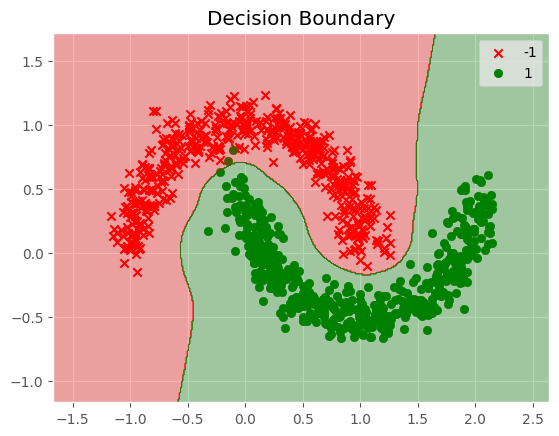

In [7]:
from matplotlib.colors import ListedColormap

x_set, y_set = x_vals, y_vals

X1, X2 = np.meshgrid(np.arange(start= x_set[:, 0].min() - 0.5, stop= x_set[:, 0].max() + 0.5, step= 0.01), 
                     np.arange(start= x_set[:, 1].min() - 0.5, stop= x_set[:, 1].max() + 0.5, step= 0.01))

y_grid = predict(tf.constant(np.c_[X1.ravel(),X2.ravel()], dtype= tf.float32), alpha).numpy().reshape(X1.shape)

colors = ["red", "green"]
marker = ["x", "o"]
for i, label in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == label, 0], x_set[y_set == label, 1], c = colors[i], marker= marker[i], label= label)

plt.contourf(X1, X2, y_grid, cmap= ListedColormap(("red", "green")), alpha= 0.3)
plt.title("Decision Boundary")
plt.legend()
plt.show()